### Перевод эксель в csv

In [1]:
import pandas as pd

df = pd.read_excel('Students_Performance_data_set.xlsx')
df.to_csv('Students_Performance_data_set.csv', index=False, encoding='utf-8')

### Предобработках данных

In [2]:
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, KBinsDiscretizer

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

file_path = "Students_Performance_data_set.xlsx"
df = pd.read_excel(file_path)

df.columns = [c.strip() for c in df.columns]

col_renames = {
    'University Admission year': 'admission_year',
    'Gender': 'gender',
    'Age': 'age',
    'H.S.C passing year': 'hsc_year',
    'Program': 'program',
    'Current Semester': 'current_semester',
    'Do you have meritorious scholarship ?': 'merit_scholarship',
    'Do you use University transportation?': 'use_transport',
    'How many hour do you study daily?': 'study_hours_daily',
    'How many times do you seat for study in a day?': 'study_freq_daily',
    'What is your preferable learning mode?': 'learning_mode',
    'Do you use smart phone?': 'use_smartphone',
    'Do you have personal Computer?': 'have_pc',
    'How many hour do you spent daily in social media?': 'social_media_hours',
    'Status of your English language proficiency': 'english_proficiency',
    'Average attendance on class': 'attendance_pct',
    'Did you ever fall in probation?': 'probation',
    'Did you ever got suspension?': 'suspension',
    'Do you attend in teacher consultancy for any kind of academical problems?': 'teacher_consultancy',
    'What are the skills do you have ?': 'skills',
    'How many hour do you spent daily on your skill development?': 'skill_hours_daily',
    'What is you interested area?': 'interest_area',
    'What is your relationship status?': 'relationship_status',
    'Are you engaged with any co-curriculum activities?': 'co_curriculum',
    'With whom you are living with?': 'living_with',
    'Do you have any health issues?': 'health_issues',
    'What was your previous SGPA?': 'prev_sgpa',
    'Do you have any physical disabilities?': 'physical_disability',
    'What is your current CGPA?': 'current_cgpa',
    'How many Credit did you have completed?': 'credits_completed',
    'What is your monthly family income?': 'monthly_income'
}

df = df.rename(columns={k: v for k, v in col_renames.items() if k in df.columns})

# Очистка

df.dropna(how="all", inplace=True)
df.dropna(axis=1, how="all", inplace=True)
df.drop_duplicates(inplace=True)

num_cols = df.select_dtypes(include=["int", "float"]).columns.tolist()
cat_cols = df.select_dtypes(include=["object"]).columns.tolist()

# Ручная коррекция: attendance_pct должна быть числовой
if 'attendance_pct' in cat_cols:
    cat_cols.remove('attendance_pct')
    df['attendance_pct'] = pd.to_numeric(df['attendance_pct'], errors='coerce')
    num_cols.append('attendance_pct')

# Заполняем пропуски
for col in num_cols:
    df[col] = df[col].fillna(df[col].median())

for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

# набор для кластеризации

X_cluster = df.copy()

# Кодируем категориальные
ordinal_encoder = OrdinalEncoder()
X_cluster[cat_cols] = ordinal_encoder.fit_transform(X_cluster[cat_cols])

# Масштабирование
scaler = StandardScaler()
X_cluster_scaled = scaler.fit_transform(X_cluster)

# набор для Байесовской сети
X_bayes = df.copy()

# те же коды категорий
X_bayes[cat_cols] = ordinal_encoder.transform(X_bayes[cat_cols])

# дискретизация числовых
kb = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='quantile')
X_bayes[num_cols] = kb.fit_transform(X_bayes[num_cols])

print("=== Готово ===")
print("X_cluster shape:", X_cluster.shape)
print("X_bayes shape:", X_bayes.shape)


=== Готово ===
X_cluster shape: (1194, 31)
X_bayes shape: (1194, 31)


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 5 are removed. Consider decreasing the number of bins.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 12 are removed. Consider decreasing the number of bins.
  warnings.warn(


### Кластеризация по 4 методам

In [3]:
import os
import pickle
import numpy as np
import pandas as pd

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

os.makedirs("clusters/kmeans", exist_ok=True)
os.makedirs("clusters/gmm", exist_ok=True)
os.makedirs("clusters/agglomerative", exist_ok=True)
os.makedirs("clusters/dbscan", exist_ok=True)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

with open("clusters/scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

print("Масштабирование выполнено.\n")

print("Кластеризация KMeans")

kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)

# сохраняем метки
pd.DataFrame({"cluster": kmeans_labels}).to_csv(
    "clusters/kmeans/labels.csv",
    index=False
)

# сохраняем модель
with open("clusters/kmeans/model.pkl", "wb") as f:
    pickle.dump(kmeans, f)

print("KMeans готов.\n")


print("Кластеризация GMM")

gmm = GaussianMixture(n_components=3, covariance_type="full", random_state=42)
gmm_labels = gmm.fit_predict(X_scaled)

pd.DataFrame({"cluster": gmm_labels}).to_csv(
    "clusters/gmm/labels.csv",
    index=False
)

with open("clusters/gmm/model.pkl", "wb") as f:
    pickle.dump(gmm, f)

print("GMM готов.\n")


print("Кластеризация Agglomerative")

agg = AgglomerativeClustering(n_clusters=3)
agg_labels = agg.fit_predict(X_scaled)

pd.DataFrame({"cluster": agg_labels}).to_csv(
    "clusters/agglomerative/labels.csv",
    index=False
)

with open("clusters/agglomerative/model.pkl", "wb") as f:
    pickle.dump(agg, f)

print("Agglomerative готов.\n")


print("Кластеризация DBSCAN")

dbscan = DBSCAN(eps=1.5, min_samples=10)
dbscan_labels = dbscan.fit_predict(X_scaled)

pd.DataFrame({"cluster": dbscan_labels}).to_csv(
    "clusters/dbscan/labels.csv",
    index=False
)

with open("clusters/dbscan/model.pkl", "wb") as f:
    pickle.dump(dbscan, f)

print("DBSCAN готов.\n")

print("\nКластеризация выполнена полностью.")


Масштабирование выполнено.

Кластеризация KMeans
KMeans готов.

Кластеризация GMM
GMM готов.

Кластеризация Agglomerative
Agglomerative готов.

Кластеризация DBSCAN
DBSCAN готов.


Кластеризация выполнена полностью.


### Сравнение оценок кластеризации

Недостаточно кластеров для метода dbscan — silhouette невозможно.
Silhouette score для всех методов:

KMEANS          → 0.08847052662592449
GMM             → 0.22918404724669716
AGGLOMERATIVE   → 0.07365490115703077
DBSCAN          → None


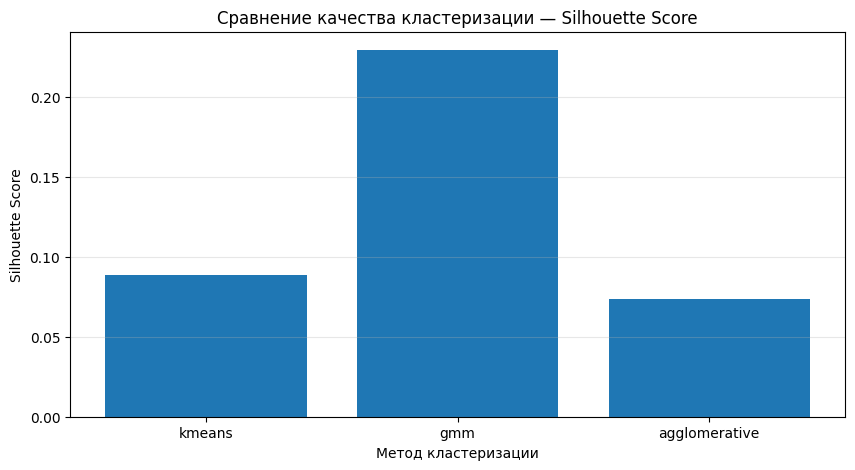

In [4]:
import pandas as pd
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

# Загружаем scaler
with open("clusters/scaler.pkl", "rb") as f:
    scaler = pickle.load(f)

# Масштабируем X
X_scaled = scaler.transform(X_cluster)

# Подгружаем метки
def load_labels(method):
    path = f"clusters/{method}/labels.csv"
    if not os.path.exists(path):
        print(f"Нет файла labels для {method}")
        return None
    return pd.read_csv(path)["cluster"].values


methods = ["kmeans", "gmm", "agglomerative", "dbscan"]
scores = {}

for m in methods:
    labels = load_labels(m)

    # DBSCAN может дать много -1
    # silhouette не работает если кластер < 2 точек
    if labels is None:
        scores[m] = None
        continue

    # если кластеров меньше 2 — силуэт невозможен
    if len(np.unique(labels)) < 2:
        scores[m] = None
        print(f"Недостаточно кластеров для метода {m} — silhouette невозможно.")
        continue

    try:
        score = silhouette_score(X_scaled, labels)
        scores[m] = score
    except:
        scores[m] = None
        print(f"Ошибка вычисления silhouette для {m}")

print("Silhouette score для всех методов:\n")
for m, sc in scores.items():
    print(f"{m.upper():15} → {sc}")

# График сравнения
plt.figure(figsize=(10, 5))
methods_clean = [m for m in methods if scores[m] is not None]
values_clean = [scores[m] for m in methods_clean]

plt.bar(methods_clean, values_clean)
plt.title("Сравнение качества кластеризации — Silhouette Score")
plt.xlabel("Метод кластеризации")
plt.ylabel("Silhouette Score")
plt.grid(axis="y", alpha=0.3)
plt.show()


### Визуальное представление кластеризации

PCA завершено. Объяснённая дисперсия: [0.13569311 0.08101556]


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP завершено.

=== KMEANS ===


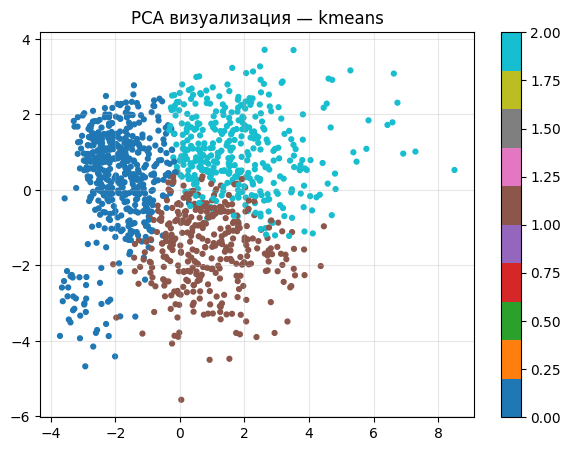

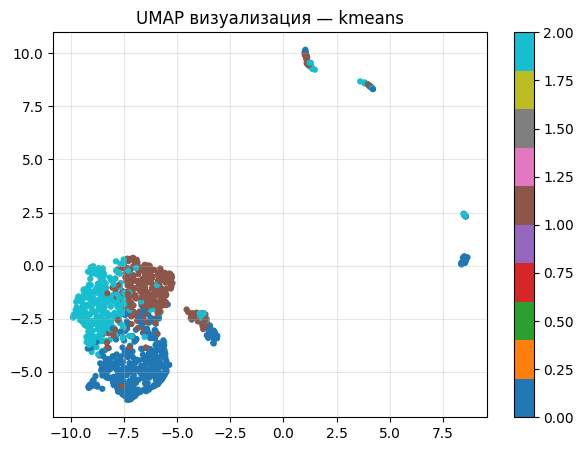


=== GMM ===


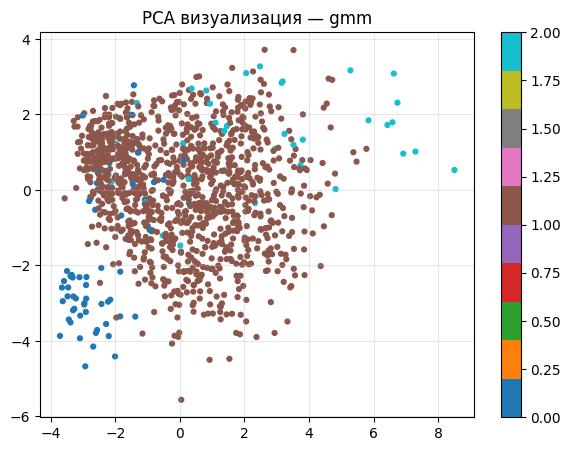

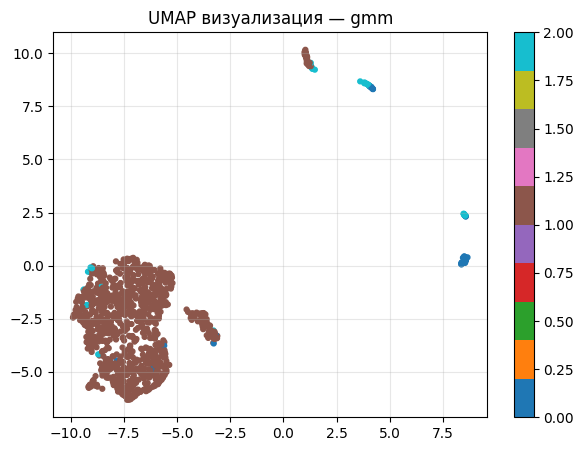


=== AGGLOMERATIVE ===


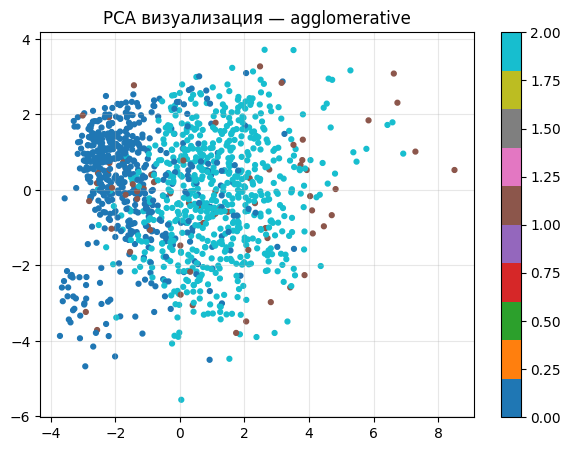

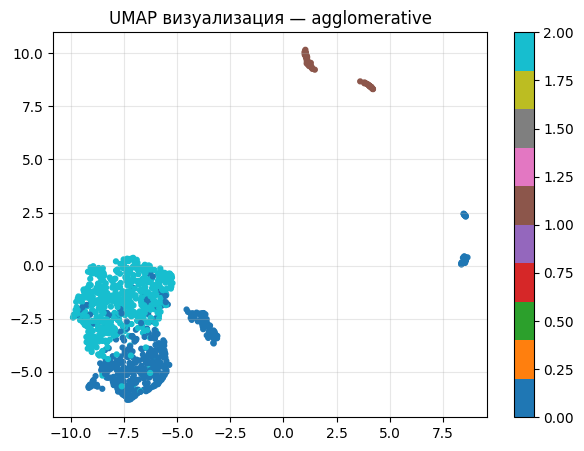


=== DBSCAN ===


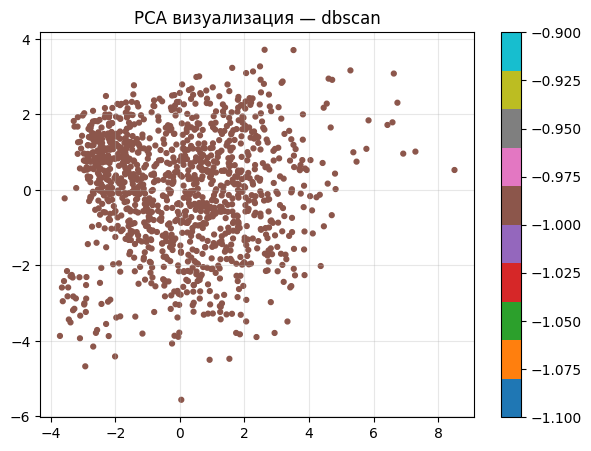

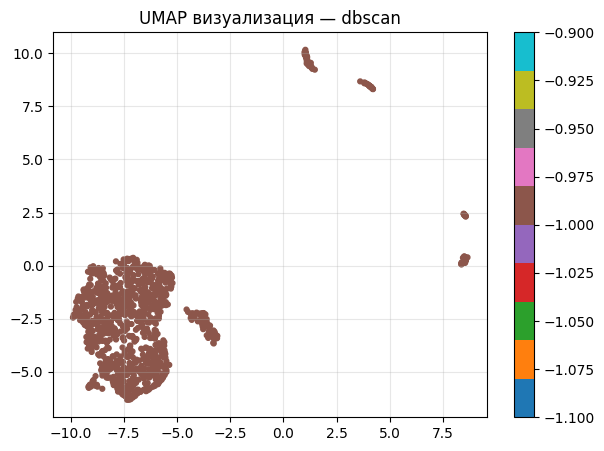

In [5]:
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

!pip install umap-learn --quiet
import umap


# Загрузка scaler
with open("clusters/scaler.pkl", "rb") as f:
    scaler = pickle.load(f)

# Масштабируем данные
X_scaled = scaler.transform(X_cluster)


# Загружаем метки
def load_labels(method):
    path = f"clusters/{method}/labels.csv"
    if not os.path.exists(path):
        print(f"Нет файла: {path}")
        return None
    return pd.read_csv(path)["cluster"].values


methods = ["kmeans", "gmm", "agglomerative", "dbscan"]
labels_dict = {m: load_labels(m) for m in methods}


# РСА
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print("PCA завершено. Объяснённая дисперсия:", pca.explained_variance_ratio_)


# UMAP
reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = reducer.fit_transform(X_scaled)

print("UMAP завершено.")


def plot_clusters(emb, labels, title):
    plt.figure(figsize=(7, 5))
    scatter = plt.scatter(emb[:, 0], emb[:, 1], c=labels, cmap="tab10", s=12)
    plt.title(title)
    plt.colorbar(scatter)
    plt.grid(alpha=0.3)
    plt.show()


for method in methods:
    labels = labels_dict[method]
    if labels is None:
        continue

    print(f"\n=== {method.upper()} ===")

    plot_clusters(X_pca, labels, f"PCA визуализация — {method}")
    plot_clusters(X_umap, labels, f"UMAP визуализация — {method}")


### Баесовская сеть

In [6]:
!pip install pgmpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 45.4 MB/s eta 0:00:00


In [7]:
import os
import pickle
import pandas as pd
from sklearn.model_selection import train_test_split
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.estimators import HillClimbSearch, BIC, MaximumLikelihoodEstimator

# Выбор метода кластеризации
method = "gmm" # варианты: "kmeans", "gmm", "agglomerative", "dbscan"

print(f"Используем метод кластеризации: {method}")


labels_path = f"clusters/{method}/labels.csv"
if not os.path.exists(labels_path):
    raise FileNotFoundError(f"Не найден файл {labels_path}")

clusters = pd.read_csv(labels_path)["cluster"]


df_bayes = X_bayes.copy()
df_bayes["target"] = clusters  # добавляем таргет

print("Размер данных для сети:", df_bayes.shape)


train_data, test_data = train_test_split(df_bayes, test_size=0.2, random_state=42)

print("Train:", train_data.shape)
print("Test:", test_data.shape)


print("\nСтроим структуру Байесовской сети...")

hc = HillClimbSearch(train_data)
best_model = hc.estimate(scoring_method=BIC(train_data))

print("Структура найдена:")
print(best_model.edges())


model = DiscreteBayesianNetwork(best_model.edges())
model.fit(train_data, estimator=MaximumLikelihoodEstimator)

print("\nБайесовская сеть обучена.")

save_dir = f"bayes_nets/{method}"
os.makedirs(save_dir, exist_ok=True)

# сохраняем структуру
with open(f"{save_dir}/structure.pkl", "wb") as f:
    pickle.dump(best_model.edges(), f)

# сохраняем модель
model.save(f"{save_dir}/model.bif")

print(f"\nСеть сохранена в папку: {save_dir}")


Используем метод кластеризации: gmm
Размер данных для сети: (1194, 32)
Train: (955, 32)
Test: (239, 32)

Строим структуру Байесовской сети...


  0%|          | 0/1000000 [00:00<?, ?it/s]

Структура найдена:
[('admission_year', 'hsc_year'), ('admission_year', 'teacher_consultancy'), ('gender', 'co_curriculum'), ('hsc_year', 'age'), ('current_semester', 'admission_year'), ('current_semester', 'target'), ('merit_scholarship', 'prev_sgpa'), ('merit_scholarship', 'probation'), ('merit_scholarship', 'relationship_status'), ('merit_scholarship', 'use_transport'), ('merit_scholarship', 'admission_year'), ('merit_scholarship', 'gender'), ('use_transport', 'living_with'), ('study_freq_daily', 'study_hours_daily'), ('english_proficiency', 'credits_completed'), ('probation', 'current_cgpa'), ('probation', 'suspension'), ('probation', 'attendance_pct'), ('relationship_status', 'living_with'), ('living_with', 'gender'), ('prev_sgpa', 'monthly_income'), ('physical_disability', 'health_issues'), ('current_cgpa', 'prev_sgpa'), ('credits_completed', 'current_semester'), ('credits_completed', 'merit_scholarship'), ('target', 'physical_disability'), ('target', 'use_smartphone'), ('target',

### Смотрим на результат

Загружаем модель байесовской сети для: gmm
Структура сети:
[('admission_year', 'hsc_year'), ('admission_year', 'teacher_consultancy'), ('credits_completed', 'current_semester'), ('credits_completed', 'merit_scholarship'), ('current_cgpa', 'prev_sgpa'), ('current_semester', 'admission_year'), ('current_semester', 'target'), ('english_proficiency', 'credits_completed'), ('gender', 'co_curriculum'), ('hsc_year', 'age'), ('living_with', 'gender'), ('merit_scholarship', 'admission_year'), ('merit_scholarship', 'gender'), ('merit_scholarship', 'prev_sgpa'), ('merit_scholarship', 'probation'), ('merit_scholarship', 'relationship_status'), ('merit_scholarship', 'use_transport'), ('physical_disability', 'health_issues'), ('prev_sgpa', 'monthly_income'), ('probation', 'attendance_pct'), ('probation', 'current_cgpa'), ('probation', 'suspension'), ('relationship_status', 'living_with'), ('study_freq_daily', 'study_hours_daily'), ('target', 'current_cgpa'), ('target', 'physical_disability'), ('targ

/usr/local/lib/python3.12/dist-packages/pgmpy/factors/discrete/DiscreteFactor.py:489: RuntimeWarning: invalid value encountered in divide
  phi.values = phi.values / (phi.values.sum())


Skipping row 83: probabilities contain NaN
['0', '1', '2']
[1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] [np.float64(0.9668395047161904), np.float64(1.0282998209896663), np.float64(1.014441741290957), np.float64(0.9668395047161904), np.float64(0.9878102002073454), np.float64(0.8846391313204897), np.float64(1.0), np.float64(1.0296

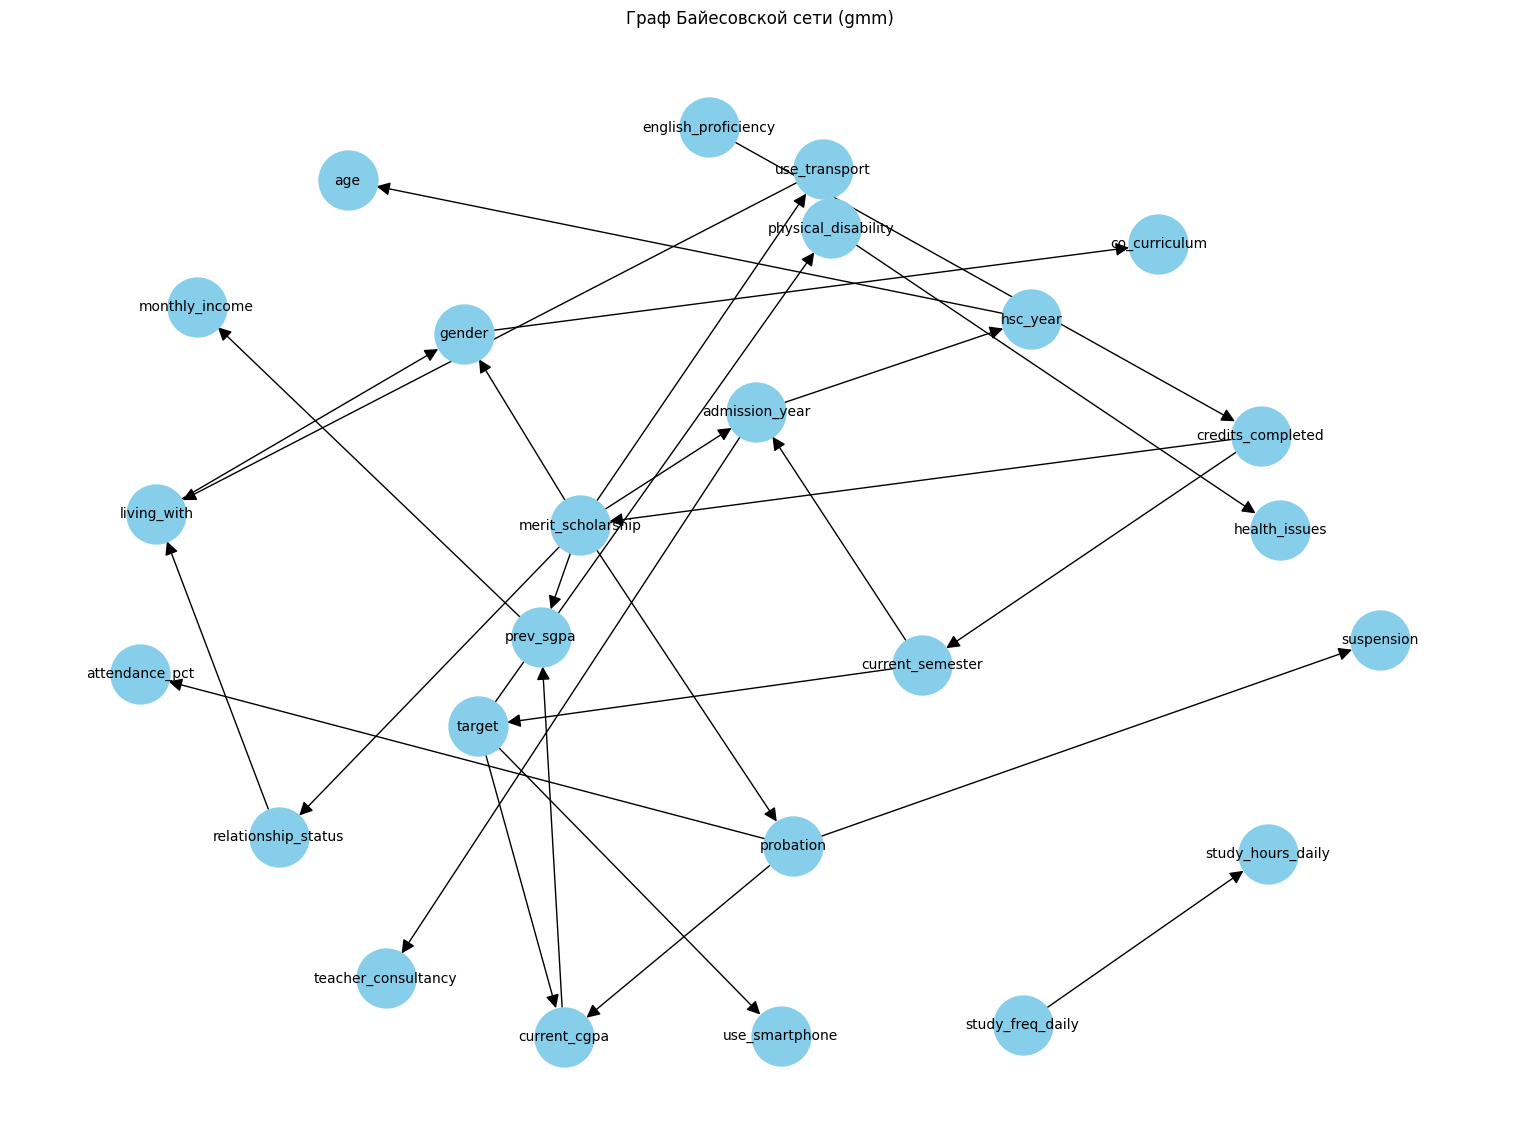

In [8]:
import pickle
import pandas as pd
from sklearn.model_selection import train_test_split
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.inference import VariableElimination
import networkx as nx
import matplotlib.pyplot as plt

method = "gmm" # варианты: "kmeans", "gmm", "agglomerative", "dbscan"

print(f"Загружаем модель байесовской сети для: {method}")

with open(f"bayes_nets/{method}/structure.pkl", "rb") as f:
    edges = pickle.load(f)


model = DiscreteBayesianNetwork()
model.add_edges_from(edges)
model = model.load(f"bayes_nets/{method}/model.bif")

print("Структура сети:")
print(model.edges())


# Загружаем кластерные метки
clusters = pd.read_csv(f"clusters/{method}/labels.csv")["cluster"]

df_bayes = X_bayes.copy()
df_bayes["target"] = clusters  # добавляем таргет

# должен совпасть с обучением
train_data, test_data = train_test_split(df_bayes, test_size=0.2, random_state=42)


infer = VariableElimination(model)

print("\nПробуем предсказывать target на тесте...")

predictions = []
true_values = []

states_map = {}
for var in model.nodes():
    cpd = model.get_cpds(var)
    if cpd is None:
        continue
    states_map[var] = cpd.state_names[var]

def fix_evidence_types(evidence, states_map):
    fixed = {}
    for var, val in evidence.items():
        allowed_states = states_map[var]

        # Нужна стркоа
        str_val = str(float(val))

        # pgmpy может хранить "0.0" для int
        if str_val in allowed_states:
            fixed[var] = str_val
        else:
            # иногда модель хранит просто "0"
            if str(int(val)) in allowed_states:
                fixed[var] = str(int(val))
            else:
                print(f"Value {val} is not a valid state for {var}. Allowed: {allowed_states}")
                fixed[var] = str(int(val - 1))
    return fixed


for idx, row in test_data.iterrows():
    relevant_cols = [col for col in model.nodes() if col != "target"]
    evidence = fix_evidence_types(row[relevant_cols].to_dict(), states_map)

    try:
        q = infer.query(variables=["target"], evidence=evidence)

        states = q.state_names['target']          # ['low','medium','high']
        probs = q.values.flatten()                # [0.1, 0.7, 0.2]

        if np.isnan(probs).any():
            print(f"Skipping row {idx}: probabilities contain NaN")
            continue

        state_codes = np.arange(len(states))
        pred = sum(code * p for code, p in zip(state_codes, probs))

        try:
            true_code = list(states).index(str(int(row["target"])))
        except ValueError:
            print(f"Skipping row {idx}: target {row['target']} not in states {states}")
            continue  # пропускаем эту строку

        predictions.append(pred)
        true_values.append(true_code)
    except Exception as e:
        print(f"### error {e}")
print(states)

import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

print(true_values, predictions)
mae = mean_absolute_error(true_values, predictions)
rmse = np.sqrt(mean_squared_error(true_values, predictions))

# Предсказания для точности
from sklearn.metrics import accuracy_score

acc = accuracy_score(true_values, np.round(predictions).astype(int))
print(f"Accuracy: {acc:.4f}")

print(f"\nMAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")


plt.figure(figsize=(15, 11))
G = nx.DiGraph()
G.add_edges_from(edges)

pos = nx.spring_layout(G, k=1.2, seed=42)
nx.draw(G, pos, with_labels=True, node_color="skyblue", node_size=1800, arrowsize=20, font_size=10)

plt.title(f"Граф Байесовской сети ({method})")
plt.show()


### Анализ кластеров

In [13]:
common_df = df.copy()
common_df["cluster"] = clusters  # добавляем таргет
common_df.head()

,admission_year,gender,age,hsc_year,program,current_semester,merit_scholarship,use_transport,study_hours_daily,study_freq_daily,learning_mode,use_smartphone,have_pc,social_media_hours,english_proficiency,attendance_pct,probation,suspension,teacher_consultancy,skills,skill_hours_daily,interest_area,relationship_status,co_curriculum,living_with,health_issues,prev_sgpa,physical_disability,current_cgpa,credits_completed,monthly_income,cluster
0,2018,Male,24,2016,BCSE,12,Yes,No,3,2,Offline,Yes,Yes,5,Intermediate,90.0,No,No,Yes,Software Development,2,Data Schince,Single,Yes,Bachelor,No,2.68,No,3.15,75,25000,1
1,2021,Male,22,2020,BCSE,4,Yes,Yes,3,2,Online,Yes,Yes,3,Basic,96.0,Yes,No,No,Web development,2,Event management,Single,Yes,Family,No,2.68,No,3.15,36,100000,1
2,2020,Female,21,2019,BCSE,5,No,No,3,3,Offline,Yes,Yes,3,Intermediate,80.0,No,No,Yes,Programming,1,Software,Single,No,Bachelor,No,2.68,No,3.15,50,50000,1
3,2021,Male,20,2020,BCSE,4,Yes,No,1,3,Offline,Yes,Yes,2,Intermediate,88.0,No,No,Yes,Programming,1,Artificial Intelligence,Single,No,Bachelor,Yes,2.68,No,3.15,36,62488,1
4,2021,Male,22,2019,BCSE,4,Yes,No,3,1,Online,Yes,Yes,2,Intermediate,80.0,No,No,Yes,Programming,1,Software,Relationship,No,Bachelor,Yes,2.68,No,3.15,36,50000,1


In [14]:
# Подробная статистика по каждому кластеру
print("\n" + "="*50)
print("Статистика по кластерам")
print("="*50)

for cluster_id in sorted(common_df['cluster'].unique()):
    cluster_data = common_df[common_df['cluster'] == cluster_id]

    print(f"\nКЛАСТЕР {cluster_id} (n={len(cluster_data)}):")

    # Ключевые метрики
    if 'current_cgpa' in cluster_data.columns:
        cgpa_stats = cluster_data['current_cgpa'].describe()
        print(f"  CGPA: mean={cgpa_stats['mean']:.2f}, min={cgpa_stats['min']:.2f}, max={cgpa_stats['max']:.2f}")

    if 'attendance_pct' in cluster_data.columns:
        attendance_stats = cluster_data['attendance_pct'].describe()
        print(f"  Посещаемость: mean={attendance_stats['mean']:.2f}%")

    # Самые частые категории
    print("  Самые частые значения:")
    for col in ['program', 'merit_scholarship', 'english_proficiency']:
        if col in cluster_data.columns:
            top_value = cluster_data[col].mode().iloc[0] if not cluster_data[col].mode().empty else "N/A"
            print(f"    - {col}: {top_value}")


Статистика по кластерам

КЛАСТЕР 0 (n=61):
  CGPA: mean=1.02, min=0.00, max=4.00
  Посещаемость: mean=93.23%
  Самые частые значения:
    - program: BCSE
    - merit_scholarship: Yes
    - english_proficiency: Intermediate

КЛАСТЕР 1 (n=1097):
  CGPA: mean=3.29, min=1.42, max=4.00
  Посещаемость: mean=88.08%
  Самые частые значения:
    - program: BCSE
    - merit_scholarship: No
    - english_proficiency: Intermediate

КЛАСТЕР 2 (n=36):
  CGPA: mean=3.14, min=2.00, max=3.97
  Посещаемость: mean=85.11%
  Самые частые значения:
    - program: BCSE
    - merit_scholarship: No
    - english_proficiency: Intermediate


Размер данных: (1194, 32)
Все колонки: ['admission_year', 'gender', 'age', 'hsc_year', 'program', 'current_semester', 'merit_scholarship', 'use_transport', 'study_hours_daily', 'study_freq_daily', 'learning_mode', 'use_smartphone', 'have_pc', 'social_media_hours', 'english_proficiency', 'attendance_pct', 'probation', 'suspension', 'teacher_consultancy', 'skills', 'skill_hours_daily', 'interest_area', 'relationship_status', 'co_curriculum', 'living_with', 'health_issues', 'prev_sgpa', 'physical_disability', 'current_cgpa', 'credits_completed', 'monthly_income', 'cluster']

Числовые колонки (13): ['admission_year', 'age', 'hsc_year', 'current_semester', 'study_hours_daily', 'study_freq_daily', 'social_media_hours', 'attendance_pct', 'skill_hours_daily', 'prev_sgpa', 'current_cgpa', 'credits_completed', 'monthly_income']
Категориальные колонки (18): ['gender', 'program', 'merit_scholarship', 'use_transport', 'learning_mode', 'use_smartphone', 'have_pc', 'english_proficiency', 'probation',

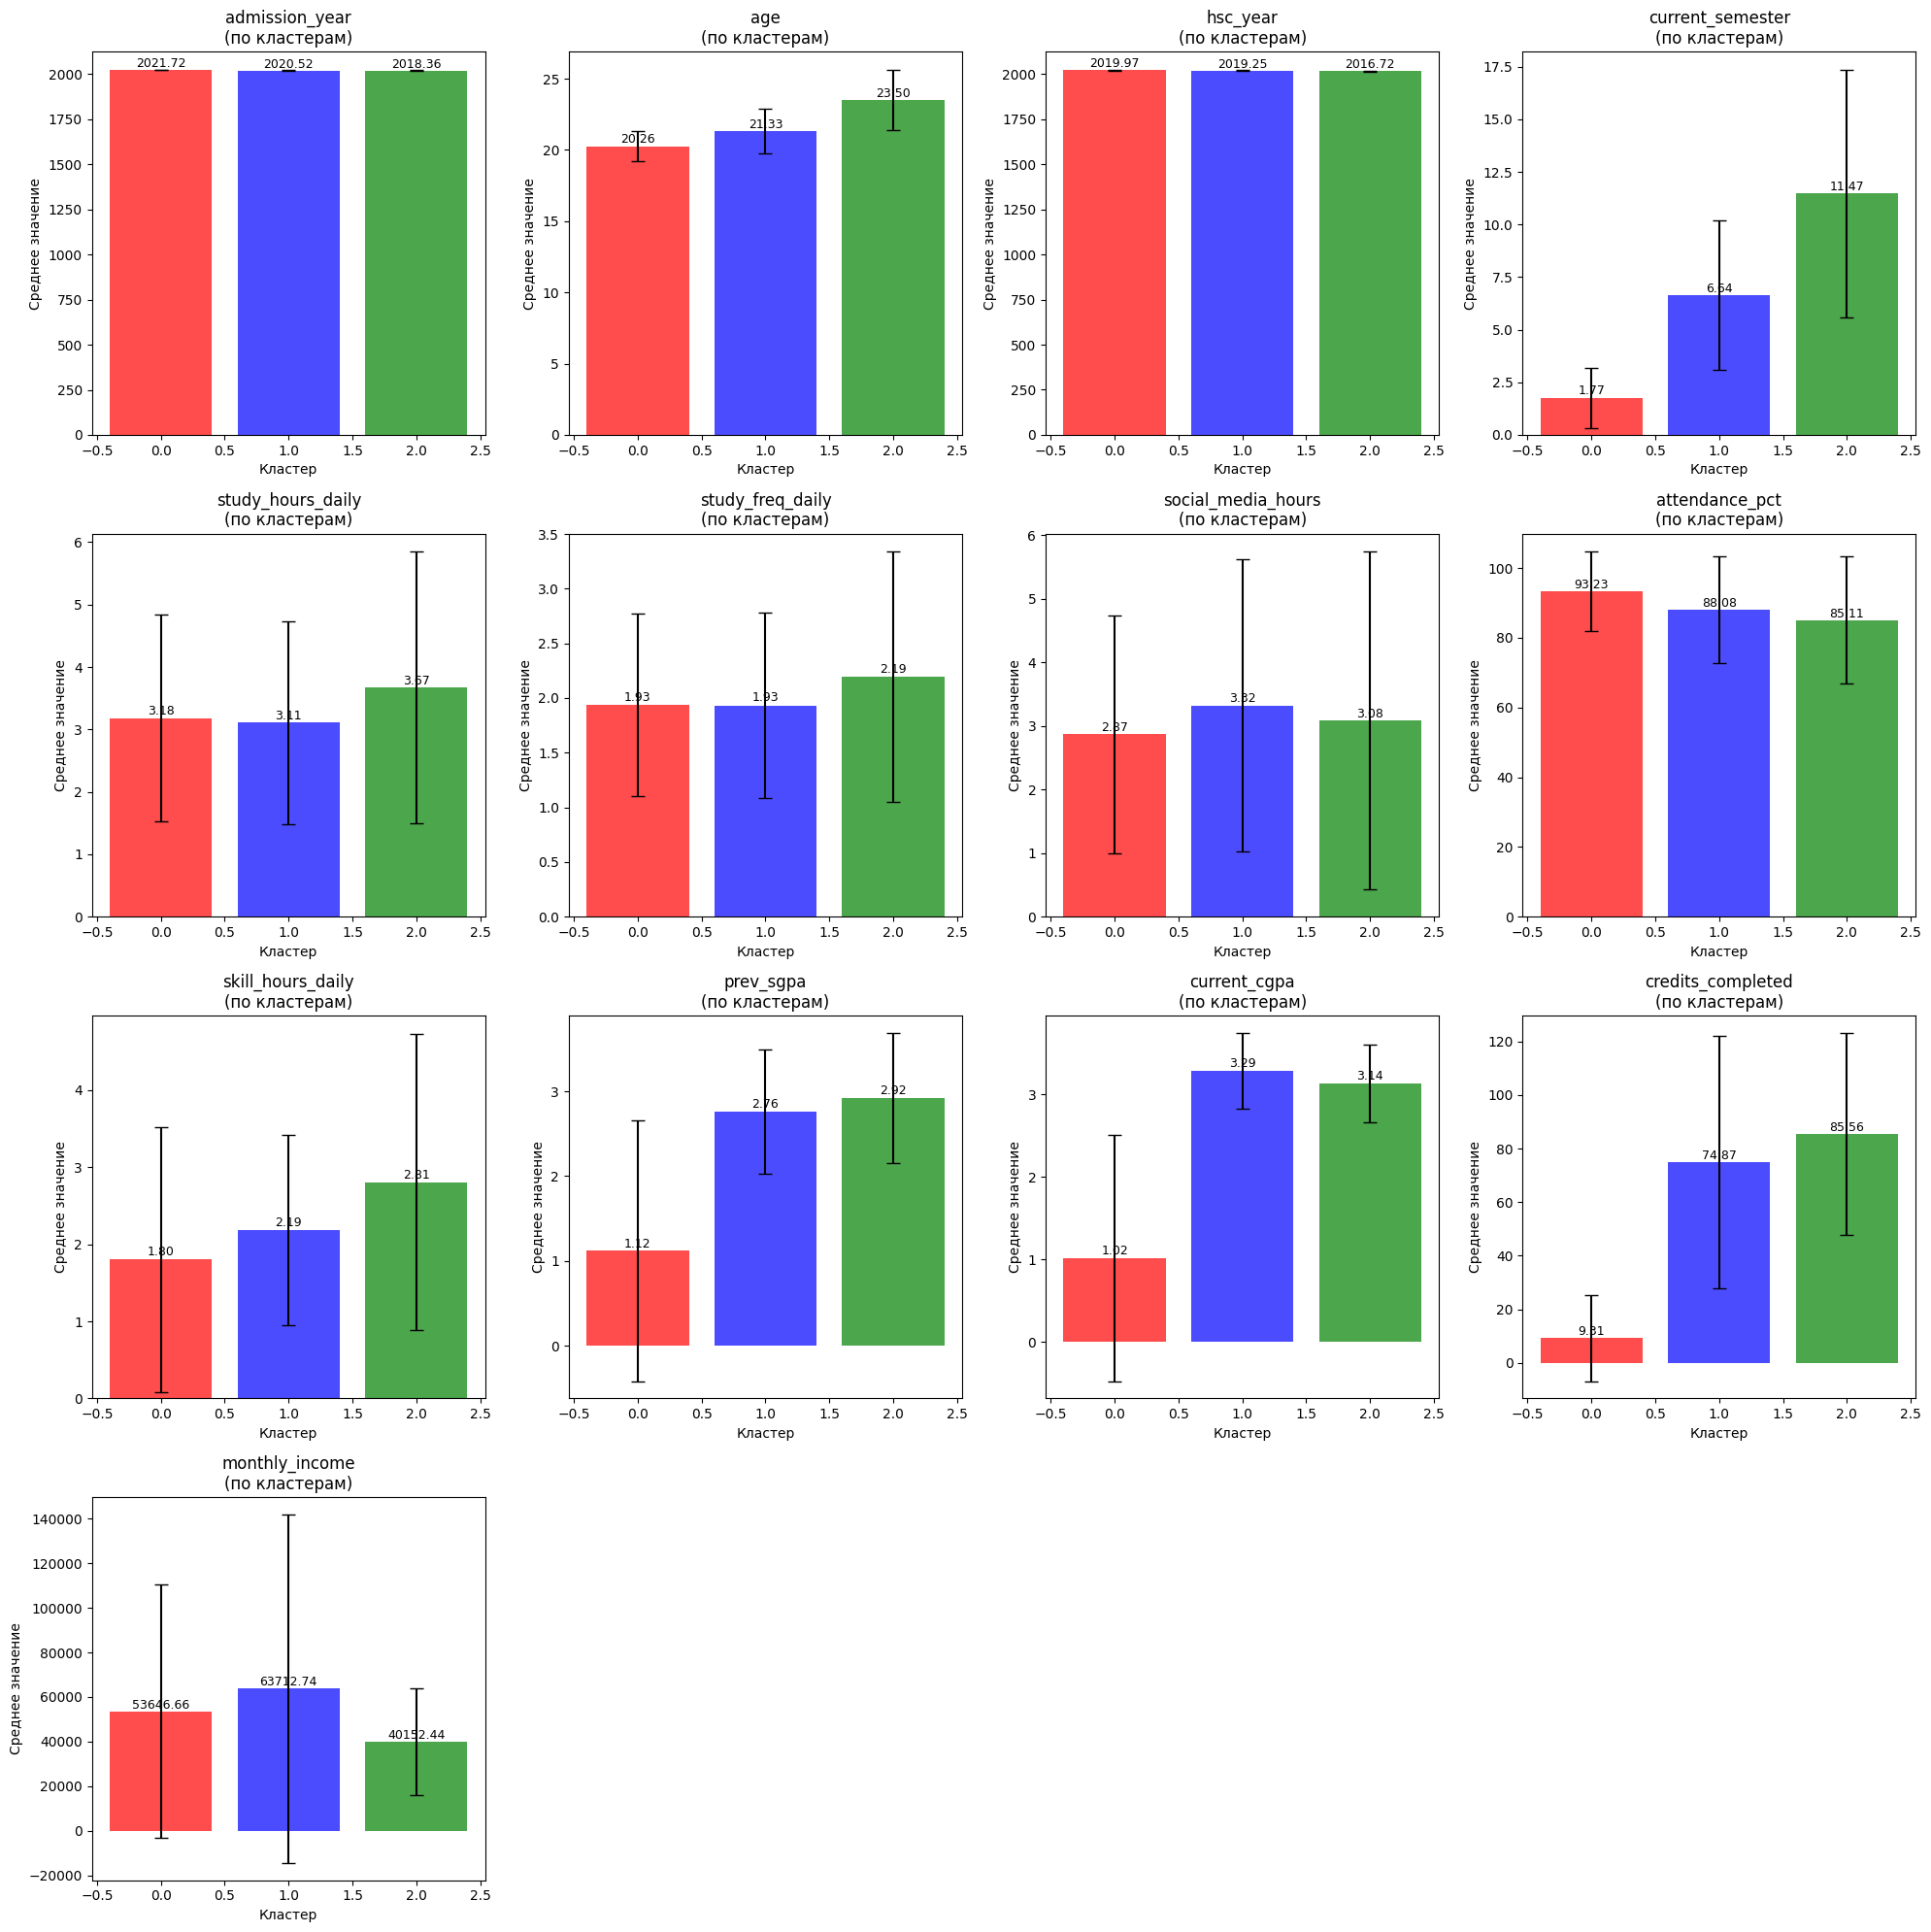


Категориальные


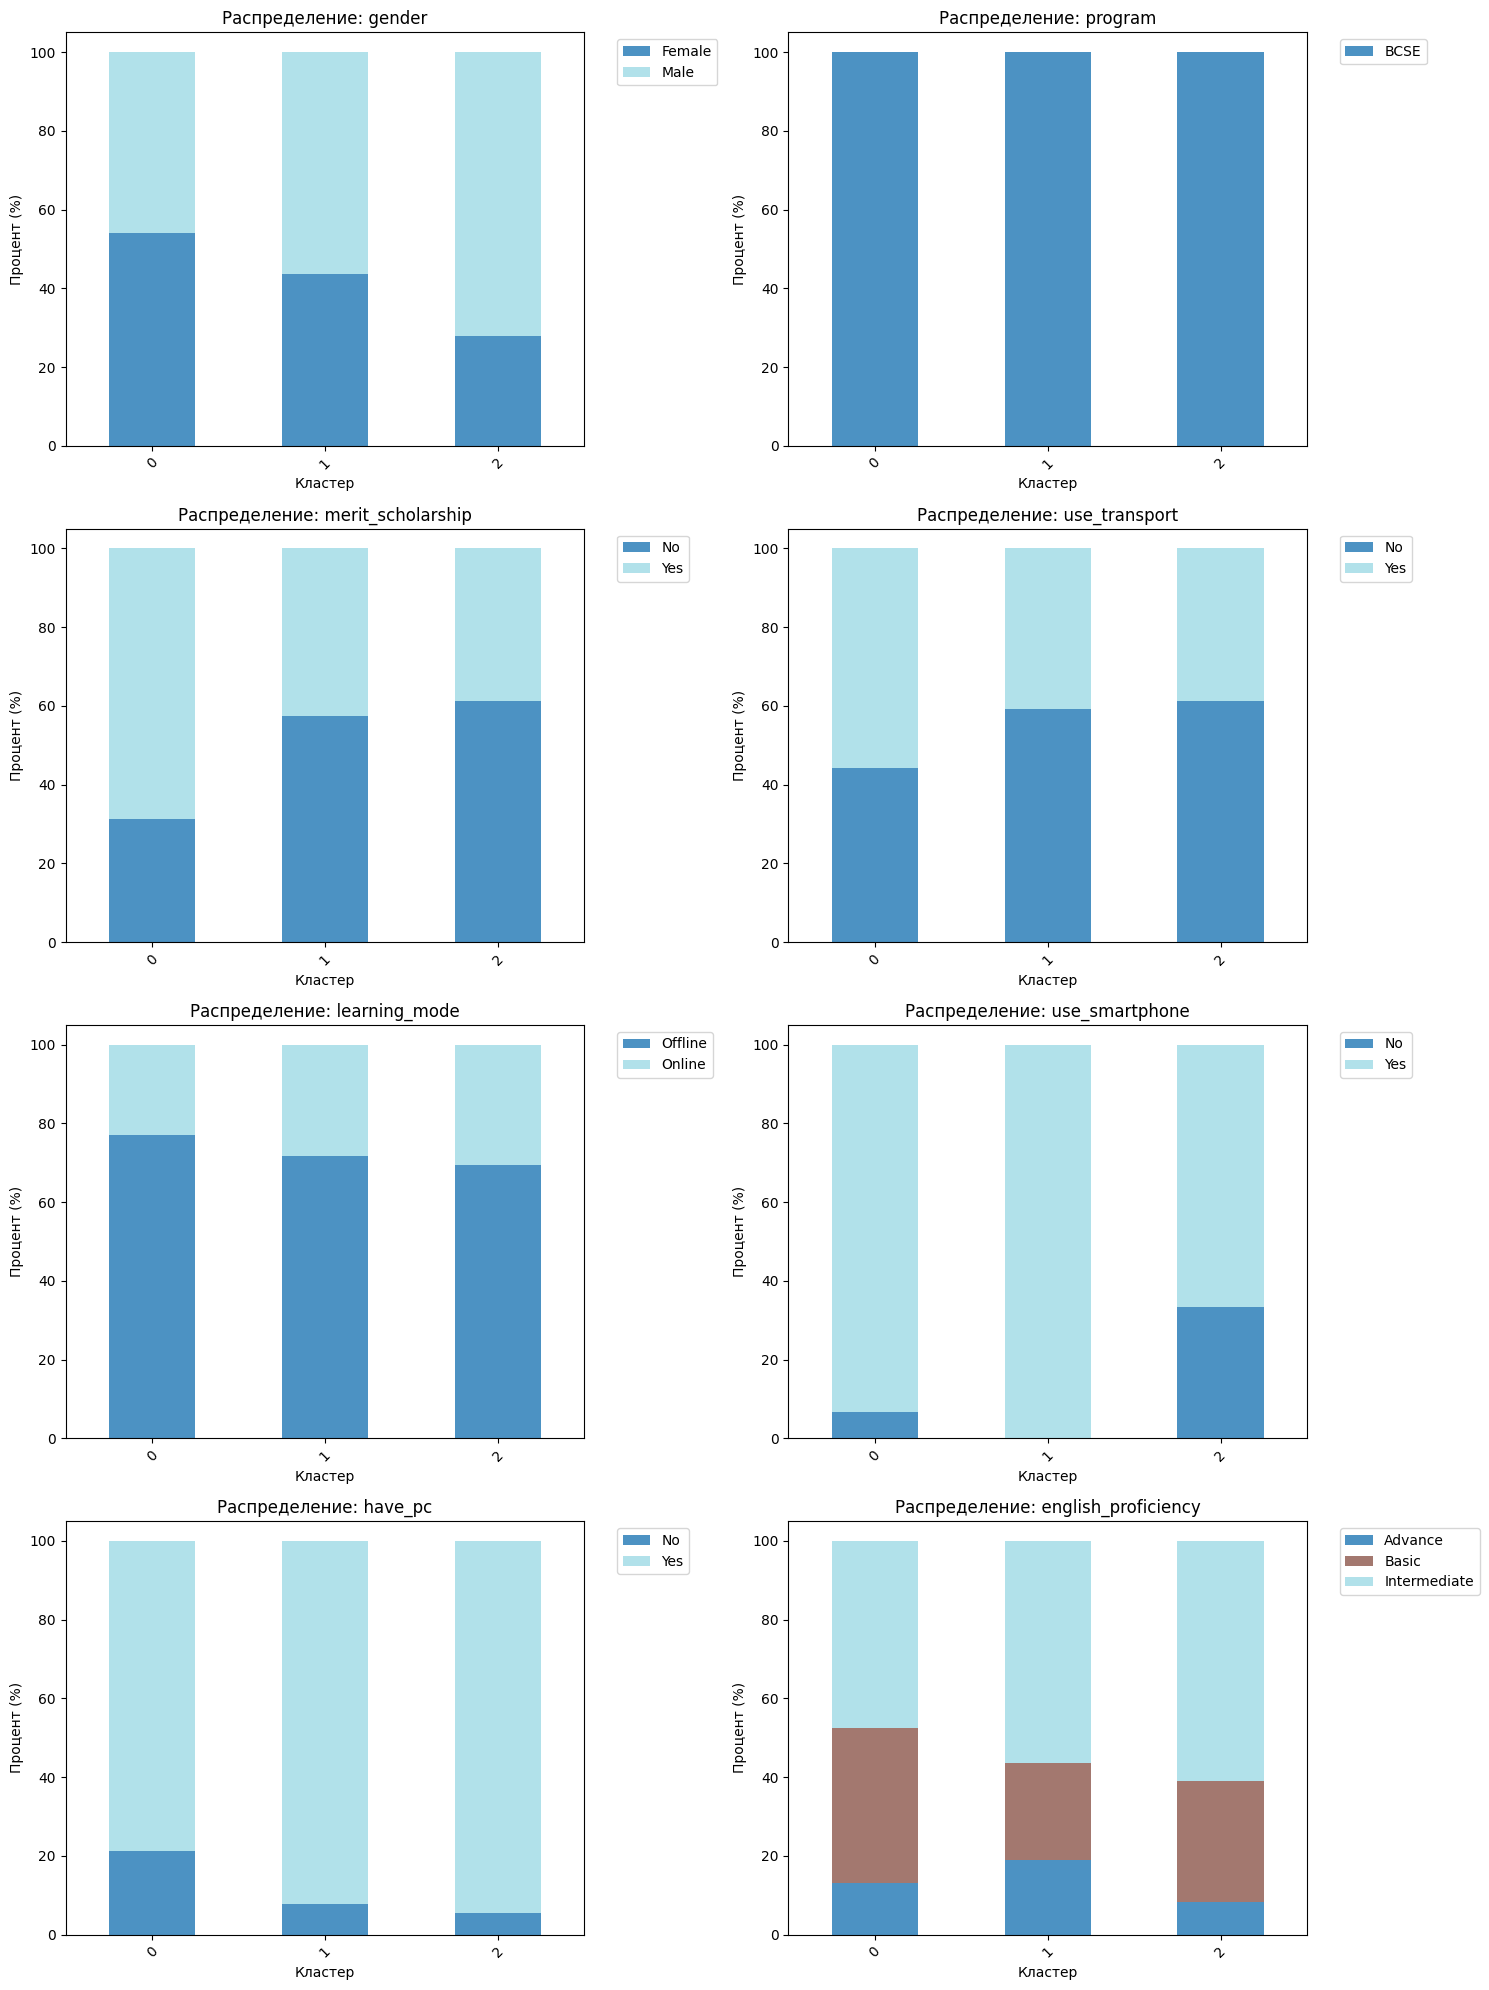


Раздичия кластеров
ANOVA тесты (p-value < 0.05 означает значимые различия):
  admission_year           : p-value = 0.0000 ЗНАЧИМО
  age                      : p-value = 0.0000 ЗНАЧИМО
  hsc_year                 : p-value = 0.0000 ЗНАЧИМО
  current_semester         : p-value = 0.0000 ЗНАЧИМО
  study_hours_daily        : p-value = 0.1348 НЕЗНАЧИМО
  study_freq_daily         : p-value = 0.1956 НЕЗНАЧИМО
  social_media_hours       : p-value = 0.2803 НЕЗНАЧИМО
  attendance_pct           : p-value = 0.0173 ЗНАЧИМО
  skill_hours_daily        : p-value = 0.0011 ЗНАЧИМО
  prev_sgpa                : p-value = 0.0000 ЗНАЧИМО


In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats


print("Размер данных:", common_df.shape)
print("Все колонки:", common_df.columns.tolist())

# Разделяем колонки по типам
numeric_cols = common_df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = common_df.select_dtypes(include=['object']).columns.tolist()

# Убираем cluster из numeric_cols
if 'cluster' in numeric_cols:
    numeric_cols.remove('cluster')

print(f"\nЧисловые колонки ({len(numeric_cols)}): {numeric_cols}")
print(f"Категориальные колонки ({len(categorical_cols)}): {categorical_cols}")

print("\n" + "="*80)
print("Все параметры")
print("="*80)

# Создаем расширенную сводную таблицу
summary_data = []

for cluster_id in sorted(common_df['cluster'].unique()):
    cluster_data = common_df[common_df['cluster'] == cluster_id]

    cluster_summary = {
        'Кластер': cluster_id,
        'Количество студентов': len(cluster_data)
    }

    # Числовые параметры
    for col in numeric_cols:
        if col in cluster_data.columns:
            mean_val = cluster_data[col].mean()
            std_val = cluster_data[col].std()
            cluster_summary[f'{col} (mean)'] = f"{mean_val:.2f}"
            cluster_summary[f'{col} (std)'] = f"{std_val:.2f}"

    # Категориальные параметры
    for col in categorical_cols:
        if col in cluster_data.columns:
            mode_val = cluster_data[col].mode()
            if not mode_val.empty:
                cluster_summary[col] = mode_val.iloc[0]
            else:
                cluster_summary[col] = "N/A"

    summary_data.append(cluster_summary)

full_summary_df = pd.DataFrame(summary_data)

transposed_summary = full_summary_df.set_index('Кластер').T
print("\nПолная характеристика кластеров:")
print(transposed_summary)


print("\n" + "="*80)
print("Графики")
print("="*80)

n_numeric = len(numeric_cols)
n_cols = 4
n_rows = (n_numeric + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
axes = axes.flatten() if n_numeric > 1 else [axes]

for i, col in enumerate(numeric_cols):
    if i < len(axes):
        # Средние значения по кластерам
        means = common_df.groupby('cluster')[col].mean()
        stds = common_df.groupby('cluster')[col].std()

        bars = axes[i].bar(means.index, means.values,
                          yerr=stds.values,
                          capsize=5,
                          alpha=0.7,
                          color=['red', 'blue', 'green', 'orange', 'purple'][:len(means)])

        axes[i].set_title(f'{col}\n(по кластерам)', fontsize=12)
        axes[i].set_xlabel('Кластер')
        axes[i].set_ylabel('Среднее значение')

        # Добавляем значения на столбцы
        for bar, mean_val in zip(bars, means.values):
            axes[i].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                        f'{mean_val:.2f}', ha='center', va='bottom', fontsize=9)

# Скрываем пустые subplots
for i in range(len(numeric_cols), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()


print("\n" + "="*80)
print("Категориальные")
print("="*80)

top_categorical = categorical_cols[:8]

n_categorical = len(top_categorical)
n_cols = 2
n_rows = (n_categorical + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
axes = axes.flatten() if n_categorical > 1 else [axes]

for i, col in enumerate(top_categorical):
    if i < len(axes):
        pivot_data = common_df.groupby(['cluster', col]).size().unstack(fill_value=0)

        pivot_pct = pivot_data.div(pivot_data.sum(axis=1), axis=0) * 100

        pivot_pct.plot(kind='bar', stacked=True, ax=axes[i],
                      colormap='tab20', alpha=0.8)

        axes[i].set_title(f'Распределение: {col}', fontsize=12)
        axes[i].set_xlabel('Кластер')
        axes[i].set_ylabel('Процент (%)')
        axes[i].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        axes[i].tick_params(axis='x', rotation=45)

# Скрываем пустые
for i in range(len(top_categorical), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()


print("\n" + "="*80)
print("Раздичия кластеров")
print("="*80)

# ANOVA тест для числовых параметров
print("ANOVA тесты (p-value < 0.05 означает значимые различия):")
for col in numeric_cols[:10]:  # ограничим первыми 10 чтобы не перегружать
    groups = [common_df[common_df['cluster'] == cluster][col] for cluster in common_df['cluster'].unique()]

    if all(len(group) > 1 for group in groups):
        f_stat, p_value = stats.f_oneway(*groups)
        significance = "ЗНАЧИМО" if p_value < 0.05 else "НЕЗНАЧИМО"
        print(f"  {col:25}: p-value = {p_value:.4f} {significance}")

Размер данных для корреляции: (1194, 32)
Все колонки: ['admission_year', 'gender', 'age', 'hsc_year', 'program', 'current_semester', 'merit_scholarship', 'use_transport', 'study_hours_daily', 'study_freq_daily', 'learning_mode', 'use_smartphone', 'have_pc', 'social_media_hours', 'english_proficiency', 'attendance_pct', 'probation', 'suspension', 'teacher_consultancy', 'skills', 'skill_hours_daily', 'interest_area', 'relationship_status', 'co_curriculum', 'living_with', 'health_issues', 'prev_sgpa', 'physical_disability', 'current_cgpa', 'credits_completed', 'monthly_income', 'target']


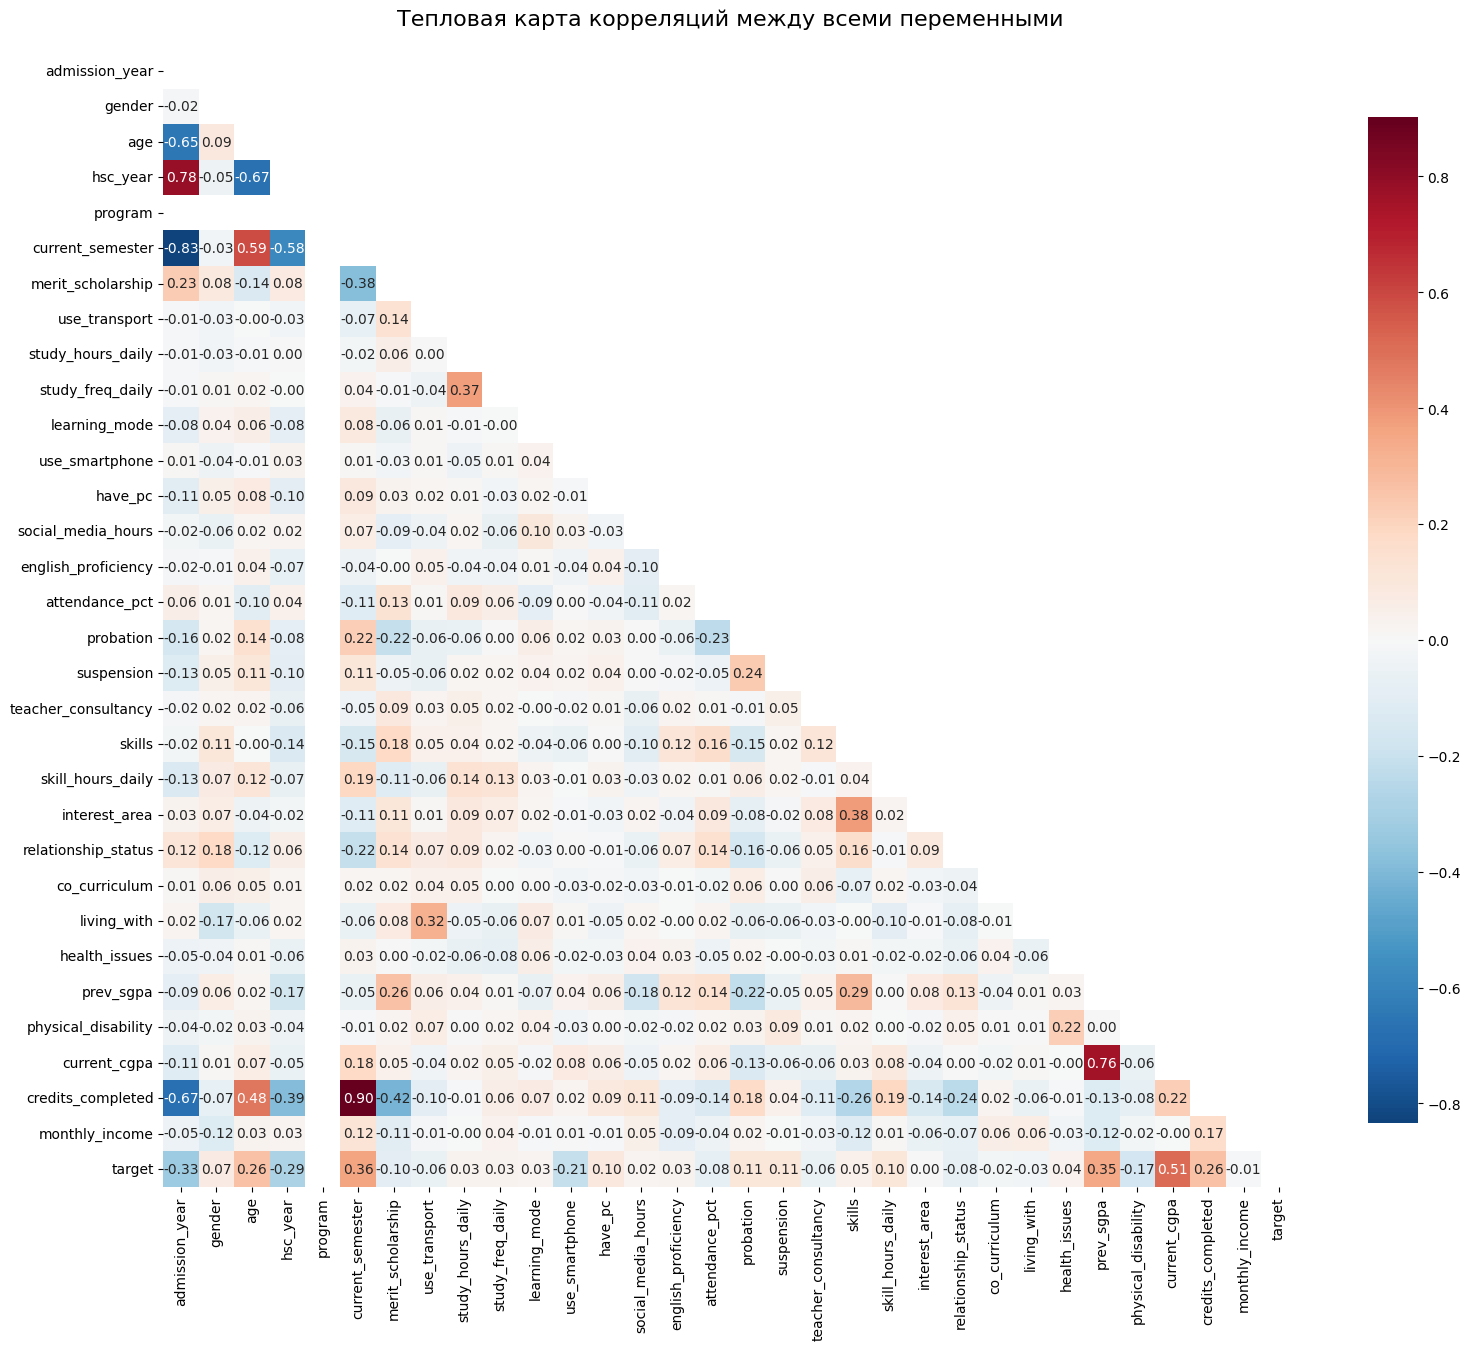

In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df_corr = common_df.copy()

from sklearn.preprocessing import LabelEncoder

categorical_cols = df_corr.select_dtypes(include=['object']).columns.tolist()

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df_corr[col] = le.fit_transform(df_corr[col].astype(str))
    label_encoders[col] = le

print("Размер данных для корреляции:", df_corr.shape)
print("Все колонки:", df_corr.columns.tolist())

correlation_matrix = df_corr.corr()

plt.figure(figsize=(16, 14))

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

sns.heatmap(correlation_matrix,
            mask=mask,
            annot=True,
            fmt='.2f',
            cmap='RdBu_r',
            center=0,
            square=True,
            cbar_kws={'shrink': 0.8})

plt.title('Тепловая карта корреляций между всеми переменными', fontsize=16, pad=20)
plt.tight_layout()
plt.show()